# 4장.GAN-생성적 적대 신경망
<p align="center">
    <img src="https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg")
<!-- ![](https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg) -->
</p>
GAN의 창시자 Ian Goodfellow </p>
출처 : https://dukakis.org/about/aiws-standards-and-practice-committee/ian-goodfellow-2/

- GAN은 2016는 NIPS 듀토리얼에서 이안 굿펠로우에 의해서 처음 발표되었음
- 이후 수 많은 생성 알고리즘이 파생됨
- GAN을 "간" 또는 "갠" 이라고 읽는데, 나는 "갠" 이라 하겠다

## 4.1 애니멀GAN
### 4.1.1 Task 소개
- Discriminator는 animalGAN 사진을 분별하고 Generator는 animalGAN 사진을 인위적으로 만들고싶어한다.
- 원본 animalGAN 사진 64장이 있다고 가정하자
    - D는 원본 64(class 1)장과 G가 랜덤하게 만들어낸 64장(class 0)을 보면서 진짜 사진을 학습한다.
    - 동시에 G는 새로운 사진 64장을 만들어내면서 D를 속이려한다.

### 4.1.2 camel(animalGAN) data 받고 확인하기
- animalGAN data를 다운로드받자 [[링크]](http://bit.ly/30HyNqg)
    1. camel.npy를 다운로드한다
    2. 이 ipynb이 있는 dir인 .에 ./data/camel folder를 만들고 거기에 다운로드받은 npy file을 넣으세요

In [1]:
import numpy as np

camel = np.load('./data/camel/full_numpy_bitmap_camel.npy')
camel.shape

(121399, 784)

In [2]:
784 == 28*28 # 아하! 28by 28 image를 flatten해서 저장했고 이런 이미지가 121399장 있구나~

True

In [3]:
import matplotlib.pyplot as plt

images = camel[0:10]
images = np.reshape(images, (-1,28,28))
print(images.shape)

(10, 28, 28)


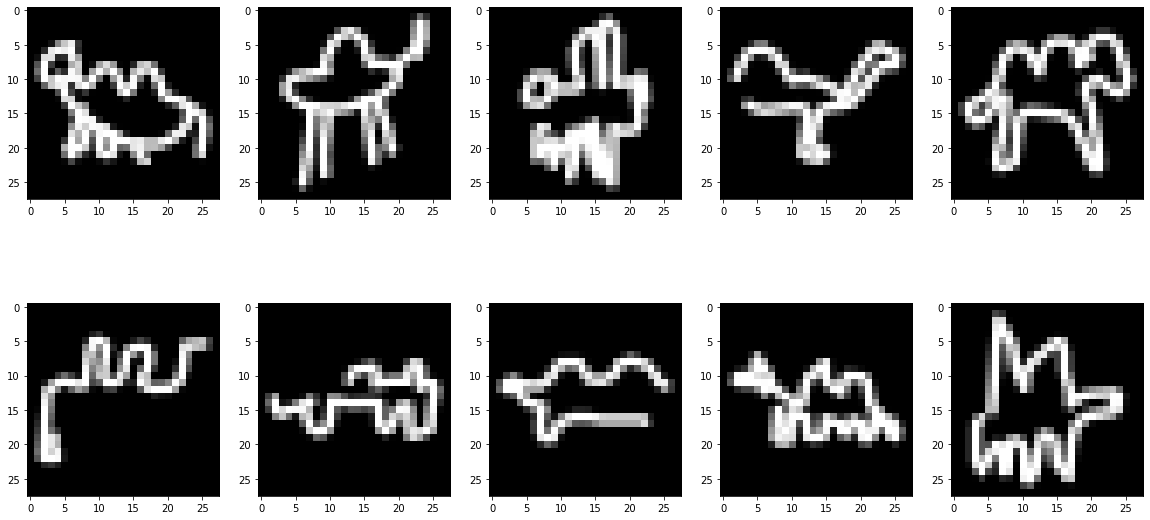

In [4]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i], cmap='gray', interpolation='none')

## 4.2 첫 번째 GAN

### 4.2.1 판별자

In [5]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, size=28):
        super().__init__()
        self.size = size
        self.layers = nn.Sequential(nn.Conv2d(1,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.4),
                                    nn.Conv2d(64,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(64,128,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(128,128,5,1,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4)
                                    )
        self.dense = nn.Linear(2048, 1)
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0],-1)
        x = self.dense(x)
        return x


if __name__ == '__main__':
    x = torch.zeros(10,1,28,28)
    D = Discriminator()
    y_pred = D(x)
    print(y_pred.shape)

torch.Size([10, 1])


In [7]:
from torchsummary import summary

D = Discriminator()
summary(D.cuda(0), (1,28,28))
del D

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
              ReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]         102,464
              ReLU-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]         204,928
              ReLU-8            [-1, 128, 4, 4]               0
           Dropout-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         409,728
             ReLU-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Linear-13                    [-1, 1]           2,049
Total params: 720,833
Trainable params:

### 4.2.2 생성자

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_1 = nn.Sequential(nn.Linear(100, 3136),
                                      nn.BatchNorm1d(3136),
                                      nn.ReLU())
        self.layers_2 = nn.Sequential(nn.Upsample(14),
                                      nn.Conv2d(64,128,5,1,2),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Upsample(28),
                                      nn.Conv2d(128,64,5,1,2),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(64,64,5,1,2),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(64,1,5,1,2),
                                      nn.ReLU())
    
    def forward(self, x):
        x = self.layers_1(x)
        x = torch.reshape(x,(x.shape[0], 64, 7, 7))
        x = self.layers_2(x)
        return x


if __name__ == '__main__':
    x = torch.zeros((10,100))
    G = Generator()
    generated = G(x)
    print(generated.shape)

torch.Size([10, 1, 28, 28])


In [9]:
G = Generator()
summary(G.cuda(0), (100,))
del G

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
       BatchNorm1d-2                 [-1, 3136]           6,272
              ReLU-3                 [-1, 3136]               0
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
       BatchNorm2d-6          [-1, 128, 14, 14]             256
              ReLU-7          [-1, 128, 14, 14]               0
          Upsample-8          [-1, 128, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]         204,864
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]         102,464
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

### 4.2.3 GAN 훈련
1. 먼저 판별자 D를 훈련하는 모델을 만든다(학습한다)
2. G는 랜덤한 인풋을 받아 가짜 이미지를 만들어 D를 속여야한다. 속이는 방향으로 G를 학습한다. 이때, D의 parameter가 업데이트되지 않아야한다.
3. 손실 함수는 판별자 D의 출력과 타깃 1사이의 CrossEntropy

In [10]:
# 데이터 준비
# 10000개만 쓰겠다. 너무 많다

images = camel[0:10000]
images.shape

(10000, 784)

In [ ]:
# 학습 변수
epochs = 20
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=VAE.parameters(),lr=lr)

In [ ]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, epoch, epochs):
    model.train()
    train_loss = 0
    for i, (image, label) in tqdm(enumerate(train_loader)):
        image, label = image.cuda(), label.cuda()
        image_recon, mu, log_var = model(image)

        loss = criterion(image_recon.cuda(), image, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'[{epoch+1}/{epochs}] training loss : {train_loss:.2f}')

# 학습
if __name__ == '__main__':
    for epoch in range(epochs):
        train(VAE, train_loader, criterion, optimizer, epoch, epochs)

## 4.3 GAN의 도전 과제

### 4.3.1 진동하는 Loss

### 4.3.2 Mode Collapse

### 4.3.2 손실함수 최적화 != 실제 생성 품질

### 4.3.3 하이퍼파라미터
- GAN은 하이퍼파라미터 세팅에 너무 민감하다
- 네트워크의 시시콜콜한 구조부터 배치, LR, Latent space의 크기, 커널 크기... 등등 뭐 하나라도 맘에 안들면 제대로 안한다

## 4.4 WGAN - 와서스테인 GAN